In [1]:
from olfactometer_ingestion import create_device, populate_software_events
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [2]:
TARGET_PATH = Path(r"C:\Users\huy.nguyen\Downloads\20240301T160321 1\20240301T160321")
OLFACTOMETER = create_device("Olfactometer")
ANALOG_INPUT = create_device("AnalogInput")
SOFTWARE_EVENTS = populate_software_events(root_path=TARGET_PATH)

In [3]:
endValve = OLFACTOMETER.EndValveState.read(TARGET_PATH/"Olfactometer.harp/Register__EndValveState.bin")
endValve.head(10)

,EndValve0,EndValve1,ValveDummy
Time,,,
681743.391488,False,False,False
681743.461504,False,False,False
681758.408480,True,False,False
681760.412480,False,False,False
681770.422496,True,False,False
681772.423488,False,False,False
681782.435488,True,False,False
681784.446496,False,False,False
681794.456480,True,False,False


In [4]:
analog = ANALOG_INPUT.AnalogData.read(TARGET_PATH/"AnalogInput.harp/Register__33.bin")["Channel0"]
analog.head(10)

Time
681742.376992    1673
681742.377984    1674
681742.378976    1676
681742.380000    1676
681742.380992    1670
681742.381984    1672
681742.382976    1670
681742.384000    1669
681742.384992    1672
681742.385984    1672
Name: Channel0, dtype: int16

In [5]:
SOFTWARE_EVENTS.keys()

dict_keys(['IsEndValveCalibration', 'OdorChannel', 'OdorConfig'])

In [6]:
odor_config = SOFTWARE_EVENTS["OdorConfig"]["data"]
odor_config = pd.DataFrame(odor_config.values.tolist(), index = odor_config.index)
odor_config = odor_config.iloc[:, 0:2]
odor_config

,channel_index,odorant
Seconds,,
681743.392000,2,AmylAcetate
681868.532992,1,AlphaPinene
681993.658976,0,Eugenol
682118.772992,2,AmylAcetate
682243.917984,1,AlphaPinene
682369.069984,0,Eugenol


In [7]:
cali_val = SOFTWARE_EVENTS['IsEndValveCalibration']['data']
cali_val = pd.DataFrame(cali_val.values.tolist(), index= cali_val.index)
cali_val = cali_val.iloc[:, 0]
cali_val

Seconds
681743.390976     True
681868.532992     True
681993.657984     True
682118.772992    False
682243.917984    False
682369.068992    False
Name: 0, dtype: bool

In [8]:
end_valve_open = endValve['EndValve0'].loc[endValve['EndValve0'].astype(float).diff() == 1.0]
end_valve_closed = endValve['EndValve0'].loc[endValve['EndValve0'].astype(float).diff() == -1.0]

print(f"end_valve_open | length: {len(end_valve_open)}\n{end_valve_open.head(5)}")
print()
print(f"end_valve_closed | length: {len(end_valve_closed)}\n{end_valve_closed.head(5)}")

end_valve_open | length: 33
Time
681758.408480    True
681770.422496    True
681782.435488    True
681794.456480    True
681806.473504    True
Name: EndValve0, dtype: bool

end_valve_closed | length: 32
Time
681760.412480    False
681772.423488    False
681784.446496    False
681796.458496    False
681808.474496    False
Name: EndValve0, dtype: bool


In [9]:
valve_status = pd.concat(
    [pd.DataFrame({'time_open' : end_valve_open.index}),
    pd.DataFrame({'time_closed': end_valve_closed.index})],
    ignore_index= True,
    axis= 1
).\
    rename(columns={0: 'time_valve_open', 1: 'time_valve_closed'})

valve_status = valve_status.fillna(max(analog.index))

In [10]:
analog.index = np.float64(analog.index)
nu_analog = analog[analog.index >= valve_status['time_valve_open'][0] - 1]

In [11]:
valve_status.loc[valve_status['time_valve_open'] >= cali_val.index[0], 'IsEndValveCalibration'] = True
valve_status.loc[valve_status['time_valve_open'] >= cali_val.index[3], 'IsEndValveCalibration'] = False

In [12]:
big_time_list = []
for i in range(len(valve_status)):
    big_time_list.append(
        nu_analog.index[(valve_status['time_valve_open'][i] - 1 <= nu_analog.index) & (nu_analog.index <= valve_status['time_valve_closed'][i] + 1)].tolist()
    )

In [13]:
big_list = []
for i in range(len(valve_status)):
    big_list.append(
        nu_analog.values[(valve_status['time_valve_open'][i] - 1 <= nu_analog.index) & (nu_analog.index <= valve_status['time_valve_closed'][i] + 1)].tolist()
    )

In [14]:
valve_status['data'] = big_list
valve_status['seconds'] = big_time_list

In [15]:
odor_list = []
index_pos = 0

for i in valve_status['time_valve_open']:
    if odor_config.index[index_pos] <= i < odor_config.index[index_pos + 1]:
        odor_list.append(odor_config['odorant'].iloc[index_pos])
    elif i >= odor_config.index[index_pos + 1]:
        odor_list.append(odor_config['odorant'].iloc[index_pos + 1])
        index_pos += 1

In [16]:
valve_status['odorant'] = odor_list
valve_status = valve_status.merge(odor_config.iloc[0:3,:], on = 'odorant', how = 'left')

In [17]:
valve_status.loc[valve_status['time_valve_open'] >= cali_val.index[0], 'IsEndValveCalibration'] = True
valve_status.loc[valve_status['time_valve_open'] >= cali_val.index[3], 'IsEndValveCalibration'] = False

In [18]:
valve_status['trial_count'] = valve_status.groupby(['channel_index', 'IsEndValveCalibration']).cumcount() + 1

In [19]:
valve_status = valve_status[['IsEndValveCalibration', 'channel_index', 'odorant', 'trial_count', 'time_valve_open', 'time_valve_closed', 'seconds', 'data']]

In [20]:
valve_status

,IsEndValveCalibration,channel_index,odorant,trial_count,time_valve_open,time_valve_closed,seconds,data
0,True,2,AmylAcetate,1,681758.408480,681760.412480,"[681757.408992, 681757.409984, 681757.410976, ...","[1699, 1703, 1704, 1703, 1705, 1707, 1705, 170..."
1,True,2,AmylAcetate,2,681770.422496,681772.423488,"[681769.422976, 681769.424, 681769.424992, 681...","[1758, 1757, 1759, 1758, 1763, 1757, 1756, 175..."
2,True,2,AmylAcetate,3,681782.435488,681784.446496,"[681781.436, 681781.436992, 681781.437984, 681...","[1790, 1792, 1789, 1786, 1782, 1789, 1788, 178..."
3,True,2,AmylAcetate,4,681794.456480,681796.458496,"[681793.456992, 681793.457984, 681793.458976, ...","[1810, 1812, 1812, 1810, 1811, 1808, 1812, 181..."
4,True,2,AmylAcetate,5,681806.473504,681808.474496,"[681805.473984, 681805.474976, 681805.476, 681...","[1830, 1830, 1829, 1830, 1836, 1828, 1828, 182..."
5,True,2,AmylAcetate,6,681818.484576,681820.487488,"[681817.484992, 681817.485984, 681817.486976, ...","[1837, 1838, 1839, 1839, 1840, 1837, 1840, 183..."
6,True,2,AmylAcetate,7,681830.498496,681832.500480,"[681829.498976, 681829.5, 681829.500992, 68182...","[1843, 1847, 1843, 1848, 1847, 1843, 1843, 184..."
7,True,2,AmylAcetate,8,681842.512480,681844.514496,"[681841.512992, 681841.513984, 681841.514976, ...","[1847, 1846, 1852, 1845, 1845, 1844, 1845, 185..."
8,True,2,AmylAcetate,9,681854.524576,681856.526496,"[681853.524992, 681853.525984, 681853.526976, ...","[1853, 1853, 1856, 1849, 1849, 1848, 1849, 184..."
9,True,2,AmylAcetate,10,681866.533504,681868.534496,"[681865.533984, 681865.534976, 681865.536, 681...","[1858, 1859, 1855, 1862, 1858, 1858, 1855, 185..."


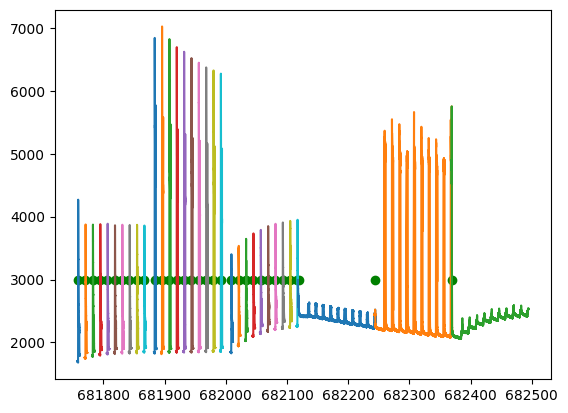

In [21]:
plt.figure()
for i, v in valve_status.iterrows():
    plt.plot(v['seconds'], v['data'])
    plt.scatter(v['time_valve_open'], 3000, color = 'g')
plt.show()

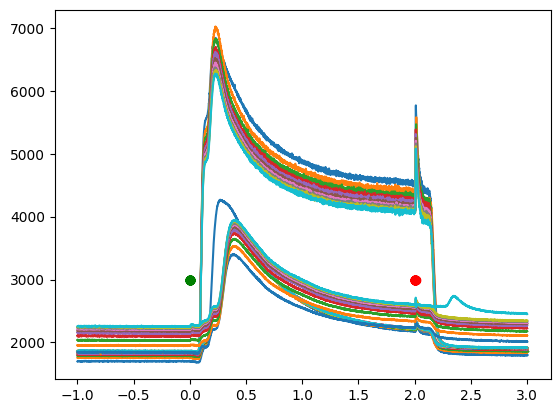

In [22]:
plt.figure()
for i, v in valve_status.iloc[0:30].iterrows():
    plt.plot([x - v['time_valve_open'] for x in v['seconds']], v['data'])
    plt.scatter((v['time_valve_open'] - v['time_valve_open']), 3000, color = 'g')
    plt.scatter((v['time_valve_closed'] - v['time_valve_open']), 3000, color = 'r')
plt.show()

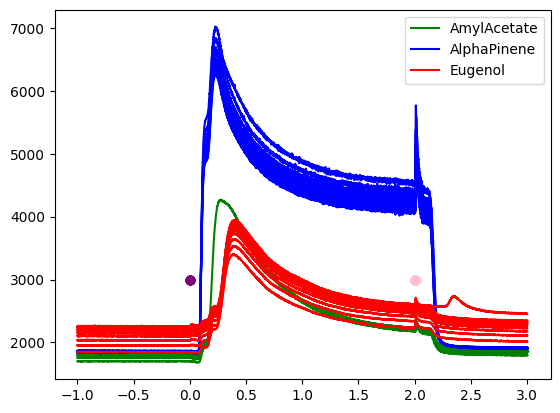

In [23]:
plt.figure()
for i, v in valve_status.iloc[0:30].iterrows():
    if v['channel_index'] == 0:
        col = 'r'
        lab = 'Eugenol'
    elif v['channel_index'] == 1:
        col = 'b'
        lab = 'AlphaPinene'
    else:
        col = 'g'
        lab = 'AmylAcetate'
    
    plt.plot([x - v['time_valve_open'] for x in v['seconds']], v['data'], color = col, label = lab)
    plt.scatter((v['time_valve_open'] - v['time_valve_open']), 3000, color = 'purple')
    plt.scatter((v['time_valve_closed'] - v['time_valve_open']), 3000, color = 'pink')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
    
plt.show()

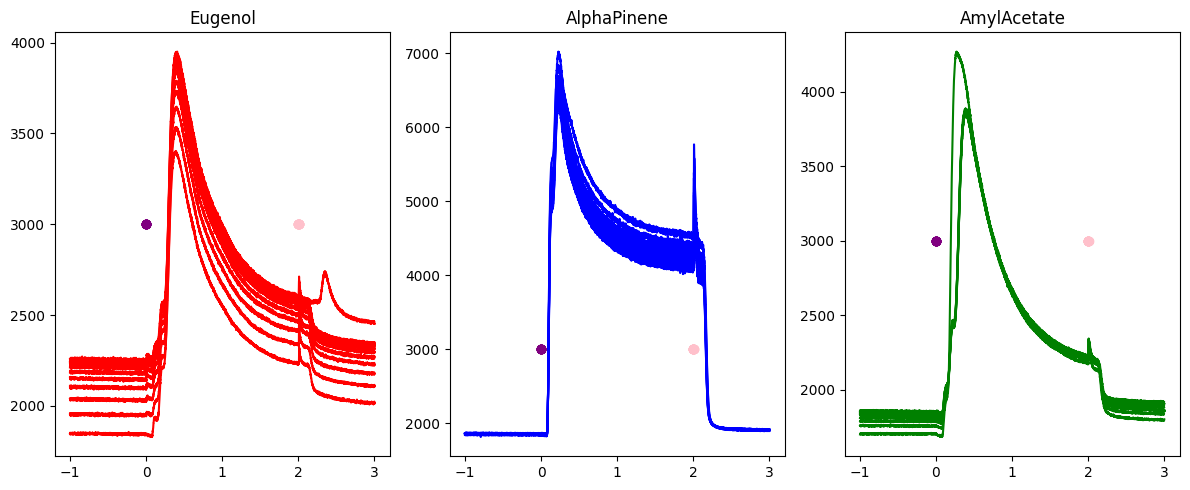

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

for i, v in valve_status[(valve_status['IsEndValveCalibration'] == True) & (valve_status['channel_index'] == 0)].iterrows():
    ax1.plot([x - v['time_valve_open'] for x in v['seconds']], v['data'], color = 'r')
    ax1.scatter((v['time_valve_open'] - v['time_valve_open']), 3000, color = 'purple')
    ax1.scatter((v['time_valve_closed'] - v['time_valve_open']), 3000, color = 'pink')
    ax1.set_title("Eugenol")

for i, v in valve_status[(valve_status['IsEndValveCalibration'] == True) & (valve_status['channel_index'] == 1)].iterrows():
    ax2.plot([x - v['time_valve_open'] for x in v['seconds']], v['data'], color = 'b')
    ax2.scatter((v['time_valve_open'] - v['time_valve_open']), 3000, color = 'purple')
    ax2.scatter((v['time_valve_closed'] - v['time_valve_open']), 3000, color = 'pink')
    ax2.set_title("AlphaPinene")
    
for i, v in valve_status[(valve_status['IsEndValveCalibration'] == True) & (valve_status['channel_index'] == 2)].iterrows():
    ax3.plot([x - v['time_valve_open'] for x in v['seconds']], v['data'], color = 'g')
    ax3.scatter((v['time_valve_open'] - v['time_valve_open']), 3000, color = 'purple')
    ax3.scatter((v['time_valve_closed'] - v['time_valve_open']), 3000, color = 'pink')
    ax3.set_title("AmylAcetate")
    


fig.set_figheight(5)
fig.set_figwidth(12)
fig.tight_layout()

In [25]:
def interpolate(inp, fi):
    i, f = int(fi // 1), fi % 1  # Split floating-point index into whole & fractional parts.
    j = i+1 if f > 0 else i  # Avoid index error.
    return (1-f) * inp[i] + f * inp[j]

In [26]:
max_len = 4011 #only 32 trials so I just look it up
valve_interpolate = valve_status.copy()

valve_interpolate = valve_interpolate[valve_interpolate['IsEndValveCalibration'] == True]

In [27]:
outp_time = []
for i in valve_interpolate['seconds']:
    inp_time = i
    delta = (len(inp_time) - 1) / (max_len - 1)
    outp_time.append([interpolate(inp_time, j*delta) for j in range(max_len)])

In [28]:
outp = []
for i in valve_interpolate['data']:
    inp = i
    delta = (len(inp) - 1) / (max_len - 1)
    outp.append([interpolate(inp, j*delta) for j in range(max_len)])

In [29]:
valve_interpolate['seconds'] = outp_time
valve_interpolate['data'] = outp

In [30]:
valve_interpolate.head(10)

,IsEndValveCalibration,channel_index,odorant,trial_count,time_valve_open,time_valve_closed,seconds,data
0,True,2,AmylAcetate,1,681758.408480,681760.412480,"[681757.408992, 681757.4099822683, 681757.4109...","[1699.0, 1702.993017456359, 1703.9965087281796..."
1,True,2,AmylAcetate,2,681770.422496,681772.423488,"[681769.422976, 681769.4239974463, 681769.4249...","[1758.0, 1757.002493765586, 1758.9900249376558..."
2,True,2,AmylAcetate,3,681782.435488,681784.446496,"[681781.436, 681781.436992, 681781.437984, 681...","[1790.0, 1792.0, 1789.0, 1786.0, 1782.0, 1789...."
3,True,2,AmylAcetate,4,681794.456480,681796.458496,"[681793.456992, 681793.4579817735, 681793.4589...","[1810.0, 1811.9955112219452, 1812.0, 1810.0134..."
4,True,2,AmylAcetate,5,681806.473504,681808.474496,"[681805.473984, 681805.4749735262, 681805.4759...","[1830.0, 1830.0, 1829.004987531172, 1829.99251..."
5,True,2,AmylAcetate,6,681818.484576,681820.487488,"[681817.484992, 681817.485982021, 681817.48697...","[1837.0, 1837.9980049875312, 1838.996009975062..."
6,True,2,AmylAcetate,7,681830.498496,681832.500480,"[681829.498976, 681829.4999977017, 681829.5009...","[1843.0, 1846.9910224438904, 1843.017955112219..."
7,True,2,AmylAcetate,8,681842.512480,681844.514496,"[681841.512992, 681841.5139817735, 681841.5149...","[1847.0, 1846.0022443890273, 1851.973067331670..."
8,True,2,AmylAcetate,9,681854.524576,681856.526496,"[681853.524992, 681853.5259817736, 681853.5269...","[1853.0, 1853.0, 1855.9865336658354, 1849.0471..."
9,True,2,AmylAcetate,10,681866.533504,681868.534496,"[681865.533984, 681865.5349735261, 681865.5359...","[1858.0, 1858.9975062344138, 1855.019950124688..."


valve_odo_mean = valve_interpolate[valve_interpolate['IsEndValveCalibration'] == True].\
    groupby(['channel_index', 'odorant'], as_index= False).\
        agg(
            mean_time_valve_open = ('time_valve_open', 'mean'),
            mean_time_valve_closed = ('time_valve_closed', 'mean')
        )

valve_odo_mean['mean_seconds'] = valve_interpolate.groupby('channel_index', group_keys = False).apply(lambda g: [np.mean(k) for k in zip(*g['seconds'])], include_groups = False)
valve_odo_mean['mean_data'] = valve_interpolate.groupby('channel_index', group_keys = False).apply(lambda g: [np.mean(k) for k in zip(*g['data'])], include_groups = False)
valve_odo_mean

In [31]:
valve_odo_mean = pd.DataFrame(
    {
        'IsEndValveCalibration': [True, True, True],
        'channel_index': [2, 1, 0],
        'odorant': ['AmylAcetate', 'AlphaPinene', 'Eugenol'],
        'mean_time_valve_open': [
            np.mean(valve_interpolate['time_valve_open'][valve_interpolate['odorant'] == 'AmylAcetate']),
            np.mean(valve_interpolate['time_valve_open'][valve_interpolate['odorant'] == 'AlphaPinene']),
            np.mean(valve_interpolate['time_valve_open'][valve_interpolate['odorant'] == 'Eugenol'])
            ],
        'mean_time_valve_closed': [
            np.mean(valve_interpolate['time_valve_closed'][valve_interpolate['odorant'] == 'AmylAcetate']),
            np.mean(valve_interpolate['time_valve_closed'][valve_interpolate['odorant'] == 'AlphaPinene']),
            np.mean(valve_interpolate['time_valve_closed'][valve_interpolate['odorant'] == 'Eugenol'])
        ],
        'mean_seconds': [
            [np.mean(k) for k in zip(*valve_interpolate['seconds'][valve_interpolate['odorant'] == 'AmylAcetate'])],
            [np.mean(k) for k in zip(*valve_interpolate['seconds'][valve_interpolate['odorant'] == 'AlphaPinene'])],
            [np.mean(k) for k in zip(*valve_interpolate['seconds'][valve_interpolate['odorant'] == 'Eugenol'])]
        ],
        'mean_data': [
            [np.mean(k) for k in zip(*valve_interpolate['data'][valve_interpolate['odorant'] == 'AmylAcetate'])],
            [np.mean(k) for k in zip(*valve_interpolate['data'][valve_interpolate['odorant'] == 'AlphaPinene'])],
            [np.mean(k) for k in zip(*valve_interpolate['data'][valve_interpolate['odorant'] == 'Eugenol'])]
        ]
    }
)

In [32]:
mean_seconds_norm = []
mean_data_norm = []

for i, v in valve_odo_mean.iterrows():
    mean_seconds_norm.append([x - v['mean_time_valve_open'] for x in v['mean_seconds']])
    mean_data_norm.append([x - v['mean_data'][0] for x in v['mean_data']])
valve_odo_mean['mean_seconds_norm'] = mean_seconds_norm
valve_odo_mean['mean_data_norm'] = mean_data_norm
valve_odo_mean

,IsEndValveCalibration,channel_index,odorant,mean_time_valve_open,mean_time_valve_closed,mean_seconds,mean_data,mean_seconds_norm,mean_data_norm
0,True,2,AmylAcetate,681812.475008,681814.477891,"[681811.475488, 681811.476484381, 681811.47748...","[1812.5, 1813.6979800498752, 1813.798503740648...","[-0.9995199999539182, -0.9985236189095303, -0....","[0.0, 1.197980049875241, 1.298503740648357, 0...."
1,True,1,AlphaPinene,681937.603789,681939.606096,"[681936.6042879999, 681936.605284232, 681936.6...","[1857.8, 1857.7008728179549, 1857.998204488778...","[-0.9995008001569659, -0.99850456812419, -0.99...","[0.0, -0.09912718204509474, 0.1982044887779466..."
2,True,0,Eugenol,682062.726186,682064.727901,"[682061.7266912, 682061.7276840929, 682061.728...","[2124.3, 2124.300473815461, 2124.8961596009976...","[-0.9994943998754025, -0.9985015069833025, -0....","[0.0, 0.0004738154607366596, 0.596159600997452..."


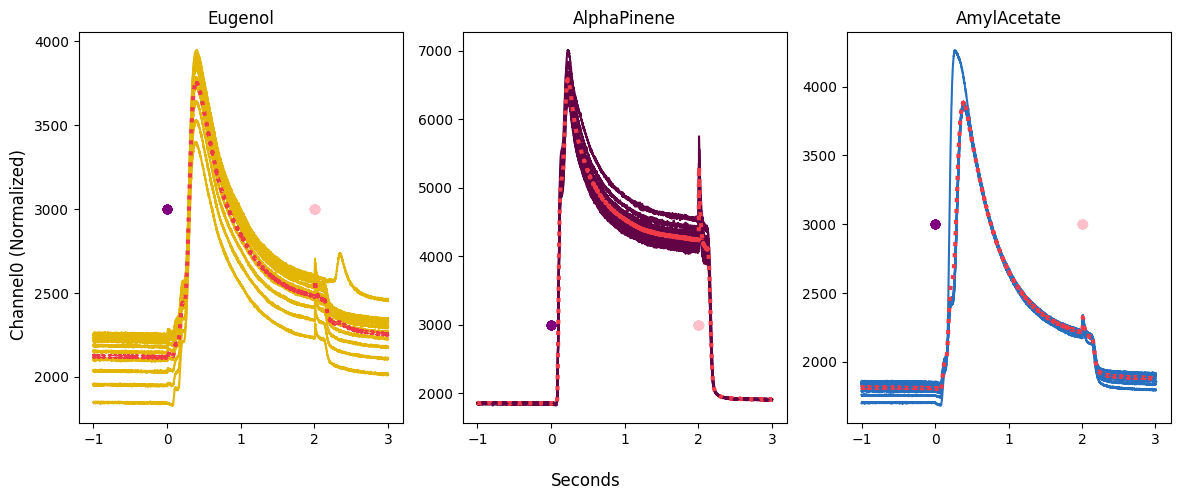

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

for i, v in valve_interpolate[(valve_interpolate['channel_index'] == 0)].iterrows():
    ax1.plot([x - v['time_valve_open'] for x in v['seconds']], v['data'], color = '#E3B505')
    ax1.scatter((v['time_valve_open'] - v['time_valve_open']), 3000, color = 'purple')
    ax1.scatter((v['time_valve_closed'] - v['time_valve_open']), 3000, color = 'pink')
    ax1.set_title("Eugenol")
    
ax1.plot(valve_odo_mean['mean_seconds_norm'][2], valve_odo_mean['mean_data'][2], color = '#F03A47', linestyle = 'dotted', linewidth = 3)    

for i, v in valve_interpolate[(valve_interpolate['channel_index'] == 1)].iterrows():
    ax2.plot([x - v['time_valve_open'] for x in v['seconds']], v['data'], color = '#610345')
    ax2.scatter((v['time_valve_open'] - v['time_valve_open']), 3000, color = 'purple')
    ax2.scatter((v['time_valve_closed'] - v['time_valve_open']), 3000, color = 'pink')
    ax2.set_title("AlphaPinene")

ax2.plot(valve_odo_mean['mean_seconds_norm'][1], valve_odo_mean['mean_data'][1], color = '#F03A47', linestyle = 'dotted', linewidth = 3)
    
for i, v in valve_interpolate[(valve_interpolate['channel_index'] == 2)].iterrows():
    ax3.plot([x - v['time_valve_open'] for x in v['seconds']], v['data'], color = '#276FBF')
    ax3.scatter((v['time_valve_open'] - v['time_valve_open']), 3000, color = 'purple')
    ax3.scatter((v['time_valve_closed'] - v['time_valve_open']), 3000, color = 'pink')
    ax3.set_title("AmylAcetate")

ax3.plot(valve_odo_mean['mean_seconds_norm'][0], valve_odo_mean['mean_data'][0], color = '#F03A47', linestyle = 'dotted', linewidth = 3)

fig.supxlabel('Seconds')
fig.supylabel('Channel0 (Normalized)')
fig.set_figheight(5)
fig.set_figwidth(12)
fig.tight_layout()

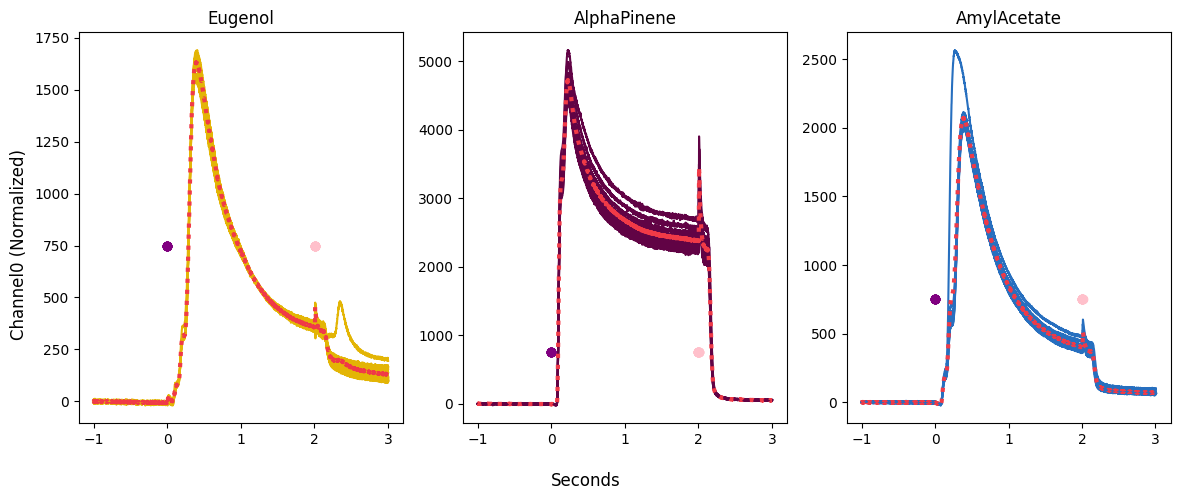

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

for i, v in valve_interpolate[(valve_interpolate['channel_index'] == 0)].iterrows():
    ax1.plot([x - v['time_valve_open'] for x in v['seconds']], [y - v['data'][0] for y in v['data']], color = '#E3B505')
    ax1.scatter((v['time_valve_open'] - v['time_valve_open']), 750, color = 'purple')
    ax1.scatter((v['time_valve_closed'] - v['time_valve_open']), 750, color = 'pink')
    ax1.set_title("Eugenol")
    
ax1.plot(valve_odo_mean['mean_seconds_norm'][2], valve_odo_mean['mean_data_norm'][2], color = '#F03A47', linestyle = 'dotted', linewidth = 3)    

for i, v in valve_interpolate[(valve_interpolate['channel_index'] == 1)].iterrows():
    ax2.plot([x - v['time_valve_open'] for x in v['seconds']],  [y - v['data'][0] for y in v['data']], color = '#610345')
    ax2.scatter((v['time_valve_open'] - v['time_valve_open']), 750, color = 'purple')
    ax2.scatter((v['time_valve_closed'] - v['time_valve_open']), 750, color = 'pink')
    ax2.set_title("AlphaPinene")

ax2.plot(valve_odo_mean['mean_seconds_norm'][1], valve_odo_mean['mean_data_norm'][1], color = '#F03A47', linestyle = 'dotted', linewidth = 3)
    
for i, v in valve_interpolate[(valve_interpolate['channel_index'] == 2)].iterrows():
    ax3.plot([x - v['time_valve_open'] for x in v['seconds']],  [y - v['data'][0] for y in v['data']], color = '#276FBF')
    ax3.scatter((v['time_valve_open'] - v['time_valve_open']), 750, color = 'purple')
    ax3.scatter((v['time_valve_closed'] - v['time_valve_open']), 750, color = 'pink')
    ax3.set_title("AmylAcetate")

ax3.plot(valve_odo_mean['mean_seconds_norm'][0], valve_odo_mean['mean_data_norm'][0], color = '#F03A47', linestyle = 'dotted', linewidth = 3)

fig.supxlabel('Seconds')
fig.supylabel('Channel0 (Normalized)')
fig.set_figheight(5)
fig.set_figwidth(12)
fig.tight_layout()